In [45]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time
import torch


review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=2000, min_df=2, max_df=0.8, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

def one_hot_encoding(array, num):
    new_list = []
    for i in array:
        temp_list = [0]*num
        temp_list[i] = 1
        new_list.append(temp_list)
    
    return new_list

def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

y_train_oh = one_hot_encoding(y_train, 2)
y_test_oh = one_hot_encoding(y_test,2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_t = torch.Tensor(X_train).to(device)
y_train_t = torch.Tensor(y_train_oh).to(device)

x_test_t = torch.Tensor(X_test).to(device)
y_test_t = torch.Tensor(y_test_oh).to(device)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pulli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pulli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def sigmoid(z):
    a = 1 / (1 + torch.exp(-z))
    return a

def softmax(z):
    exp_z = torch.exp(z)
    return exp_z / torch.sum(exp_z, axis=1).reshape(-1, 1)

In [27]:
class FCN:
    def __init__(self, architect, epochs=100, lr=0.1, l2=0, starting = 0, model_name = 'fcn'):
        # parameters
        self.w = []
        self.b = []
        self.h = []
        self.architect = architect
        self.initialize(architect)
        
        # for calculate
        self.a = [0]*(len(self.w)+1)
        self.dw = [0]*len(self.w)
        self.db = [0]*len(self.w)
        
        # log
        self.loss_log = []
        self.acc_log = []
        self.val_loss_log = []
        self.val_acc_log = []
        
        # hyper parameters
        self.start_lr = lr
        self.lr = lr
        self.l2 = l2
        
        self.epochs = epochs
        
        # ect
        self.starting = starting
        self.model_path = 'model/'
        self.model_name = model_name
        self.last_saved_time = 0
        
    
    def initialize(self, architect):
        for i in range(len(architect)-1):
            #self.w.append(torch.Tensor(np.random.normal(0, np.sqrt(2/(self.architect[i]+self.architect[i+1])) , (architect[i], architect[i+1]))).to(device))
            self.h.append(torch.Tensor(np.zeros((architect[i], architect[i+1]))).to(device))
            self.w.append(torch.Tensor(np.random.normal(0, 1, (architect[i], architect[i+1]))).to(device))
            self.b.append(torch.Tensor(np.zeros(architect[i+1])).to(device))
    
    def forpass(self, x):
        z = x.t()
        self.a[0] = z
        for i in range(len(self.w)):
            y = torch.mm(z, self.w[i]) + self.b[i]
            z = sigmoid(y)
            self.a[i+1] = z
        
        return y
    
    def backprop(self, err):
        m = len(self.a[0])
        err_h = err
        
        for i in range(len(self.w)-1, 0, -1):
            self.dw[i] = torch.mm(self.a[i].T, err_h)/ m
            if i== len(self.w)-1:
                self.db[i] = torch.sum(err_h) / m
            else:
                self.db[i] = torch.sum(err_h, axis=0) / m
            
            err_h = torch.mm(err_h, self.w[i].T ) * self.a[i] * ( 1 - self.a[i])
    
    def update(self, m):
        for i in range(len(self.w)):
            m = len(self.a[0])
            self.dw[i] += self.l2 * self.w[i] / m
            self.h[i] += self.dw[i] * self.dw[i]
            self.w[i] -= self.lr * self.dw[i] / (torch.sqrt(self.h[i]) + 1e-7)
            #self.w[i] -= self.lr * self.dw[i]
            self.b[i] -= self.lr * self.db[i]

    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = softmax(z)
        err = -(y - a)
        self.backprop(err)
        self.update(m)
        
        return a
    
    def fit(self, x, y, val_x, val_y):
        m = len(x)
        max_acc = 0.7
        for k in range(self.epochs):
            a = self.training(x, y)
            a = torch.clamp(a, min=1e-10, max=1-1e-10)
            
            loss = torch.sum(-y*torch.log(a))
            
            z_v = self.forpass(val_x)
            a_v = softmax(z_v)
            a_v = torch.clamp(a_v, min=1e-10, max=1-1e-10)
            
            val_loss = torch.sum(-val_y*torch.log(a_v))
            
            l2_sum = 0
            for i in range(len(self.w)):
                l2_sum += self.l2 / 2 * torch.sum(self.w[i]**2) / len(self.w[i])
            
            loss += l2_sum
            val_loss += l2_sum
            
            acc = torch.argmax(a, axis=1) == torch.argmax(y, axis=1)
            acc = torch.mean(acc.float())
            val_acc = torch.argmax(a_v, axis=1) == torch.argmax(val_y, axis=1)
            val_acc = torch.mean(val_acc.float())
            
            if val_acc > max_acc :
                max_acc = val_acc
                print(f"{k} : {acc} , {val_acc}")
            
            self.loss_log.append(loss.item())
            self.acc_log.append(acc.item())
            self.val_loss_log.append(val_loss.item())
            self.val_acc_log.append(val_acc.item())
            
            # decrease learning rate at each epoch
            #self.lr -=  self.start_lr / (self.epochs) * 0.1

        self.last_saved_time = int(time.time())
        self.save_model(self.epochs+self.starting, f"{self.model_name}_{self.last_saved_time}_{self.epochs+self.starting}_{np.max(self.val_acc_log):>.8}"  + ".pt")
                
    def predict(self,x):
        z = self.forpass(x)
        a = softmax(z)

        return torch.argmax(a, axis=1)
        
    def save_model(self, epoch, name):
        torch.save({
            'epoch': epoch,
            'acc' : self.acc_log,
            'loss': self.loss_log,
            'val_loss' : self.val_loss_log,
            'val_acc' : self.val_acc_log,
            'w' : self.w,
            'b' : self.b,
            'slr':self.start_lr,
            'lr': self.lr,
            'l2': self.l2,
        }, self.model_path + name)
    
    def load_model(self, name, new_epoch):
        saved_model = torch.load(self.model_path + name)
        self.starting = saved_model['epoch']
        self.start_lr = saved_model['slr']
        self.lr = saved_model['lr']
        self.l2 = saved_model['l2']
        self.w = saved_model['w']
        self.b = saved_model['b']
        #self.acc_log = saved_model['acc']
        #self.loss_log = saved_model['loss']
        #self.val_acc = saved_model['val_acc']
        #self.val_loss = saved_model['val_loss']
        self.a = [0]*(len(self.w)+1)
        self.dw = [0]*len(self.w)
        self.db = [0]*len(self.w)
        self.epochs = new_epoch

In [4]:
def draw_acc(fcn, save=False, name='', show=True):
        plt.plot(np.squeeze(fcn.acc_log), color='b', label='train')
        plt.plot(np.squeeze(fcn.val_acc_log), color='r', label='test')
        plt.ylabel('accuracy')
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(fcn.start_lr)+"  L2 =" + str(fcn.l2) + " model : " + str(fcn.model_name))
        if save:
            plt.savefig(name)
            plt.cla()
        if show:
            plt.show()
        
            
        
def draw_err(fcn, save=False, name='',show=True):
        plt.plot(np.squeeze(fcn.loss_log), color='b', label='train')
        plt.plot(np.squeeze(fcn.val_loss_log), color='r', label='test')
        plt.ylabel('loss')            
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(fcn.start_lr)+"  L2 =" + str(fcn.l2) + " model : " + str(fcn.model_name))
        if save:
            plt.savefig(name)
            plt.cla()
        if show:
            plt.show()

17909 : 0.9271948337554932 , 0.7004991769790649
17969 : 0.9271948337554932 , 0.70216304063797
18024 : 0.9279085993766785 , 0.703826904296875
18301 : 0.9286224246025085 , 0.7054908275604248
19717 : 0.9343326091766357 , 0.7071547508239746
19949 : 0.935046374797821 , 0.7088186144828796
23259 : 0.9471805691719055 , 0.7104824781417847
23372 : 0.9471805691719055 , 0.7121464014053345
29015 : 0.9664525389671326 , 0.7138103246688843
29181 : 0.9678800702095032 , 0.7154741883277893
29201 : 0.9678800702095032 , 0.7171380519866943
30463 : 0.9700214266777039 , 0.7188019752502441
30617 : 0.9707351922988892 , 0.720465898513794
32676 : 0.9771591424942017 , 0.722129762172699
34631 : 0.978586733341217 , 0.723793625831604
34847 : 0.9800142645835876 , 0.7254575490951538
35758 : 0.9800142645835876 , 0.7271214723587036
41487 : 0.9835831522941589 , 0.7287853360176086
45442 : 0.9871520400047302 , 0.7304491996765137
45908 : 0.9885795712471008 , 0.7321131229400635
47857 : 0.9885795712471008 , 0.7337770462036133


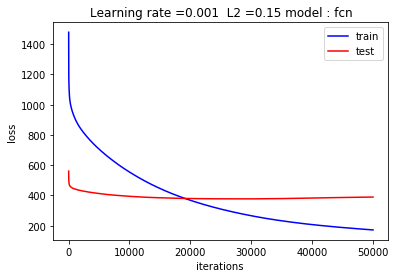

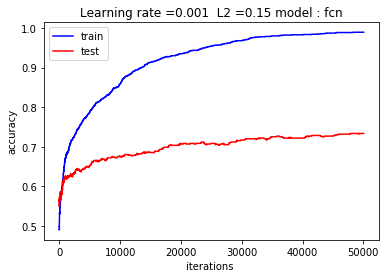

In [54]:
simple = [2000, 500, 100, 10, 2]

np.random.seed(100)
n1 = FCN(simple, epochs=50054, l2=0.15, lr = 0.001)
n1.fit(x_train_t.T, y_train_t, x_test_t.T , y_test_t )

y_pred_test_t = n1.predict(x_test_t.T).cpu()
y_pred_train_t = n1.predict(x_train_t.T).cpu()


y_pred_test = [y.item() for y in y_pred_test_t]
y_pred_train = [y.item() for y in y_pred_train_t]

print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print(accuracy_score(y_train, y_pred_train))

print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test, y_pred_test))

draw_err(n1)
draw_acc(n1)